# PC algorithm for causal discovery from observational data without latent confounders

In this tutorial, we will demonstrate how to use the PC algorithm to learn a causal graph structure and highlight some of the common challenges in applying causal discovery algorithms to data.

The PC algorithm works on observational data when there are no unobserved latent confounders.

In [1]:
import bnlearn as bn
import networkx as nx
import numpy as np

from pywhy_graphs import CPDAG
from pywhy_graphs.viz import draw

from dodiscover import PC, make_context
from dodiscover.ci import GSquareCITest, Oracle

In [2]:
# Load example dataset
data = bn.import_example(data='asia')
data.rename(columns = {
    'tub': 'T',
    'lung': 'L',
    'bronc': 'B',
    'asia': 'A',
    'smoke': 'S',
    'either': 'E',
    'xray': 'X',
    'dysp': 'D'},
    inplace=True
)
data.head()

[bnlearn] >Extracting files..


,A,T,S,L,B,E,X,D
0,1,1,1,1,1,1,1,1
1,1,1,0,0,0,0,0,0
2,1,1,0,1,0,1,1,1
3,1,1,0,1,0,1,1,0
4,1,1,1,1,1,1,1,1


We'll use the PC algorithm to infer the ASIA network.  The ASIA network is a case study of an expert system for diagnosing lung disease from Lauritzen and Spiegelhalter (1988).  Given respiratory symptions and other evidence, the goal is to distinguish between tuberculosis, lung cancer or bronchitis in a given patient.

Our goal is to discover this graph structure from observational data.  To this end, we'll use the dodiscover implementation of the PC algorithm.  First, we'll implement the ground truth graph.

In [3]:
ground_truth_edges = [
        ("A", "T"),
        ("T", "E"),
        ("L", "E"),
        ("S", "L"),
        ("S", "B"),
        ("B", "D"),
        ("E", "D"),
        ("E", "X")
    ]

ground_truth = nx.DiGraph(ground_truth_edges)

The ground truth DAG can be visualized and is seen as follows:

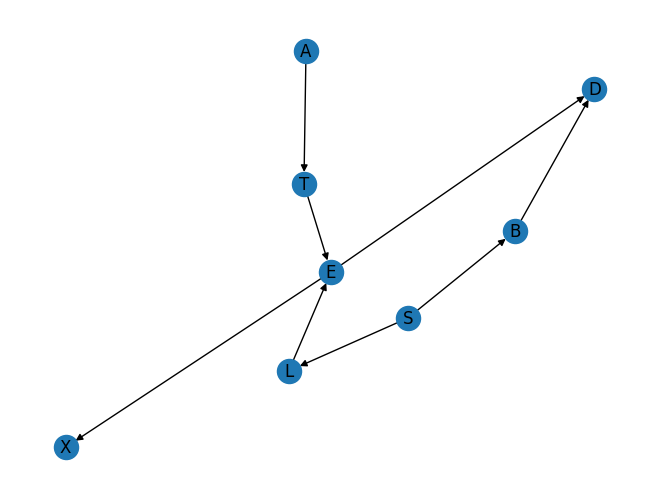

In [4]:
pos = nx.spring_layout(ground_truth, seed=1234)
nx.draw(ground_truth, with_labels=True, pos=pos)

The variables in the DAG have the following interpretation:

* T: Whether or not the patient has **tuberculosis**.
* L: Whether or not the patient has **lung cancer**.
* B: Whether or not the patient has **bronchitis**.
* A: Whether or not the patient has recently visited **Asia**.
* S: Whether or not the patient is a **smoker**.
* E: An indicator of whether the patient has either lung cancer or tuberculosis (or both).
* X: Whether or not a chest X-ray shows evidence of tuberculosis or lung cancer.
* D: Whether or not the patient has **dyspnoea** (difficulty breathing).

Note we have three kinds of variables, diseases (B, L, T, and E which indicates one or more diseases), symptoms (X and D), and behaviors (S and A).  The goal of the model is to use symptoms and behaviors to diagnose (i.e. infer) diseases.  Further, note that diseases are causes of symptoms, and are effects of behaviors.

This is the ground truth, but ground truth is not learnable from observational data alone.  We can only learn a CPDAG (complete partially directed acyclic graph), which has a mixture of directed and undirected graph.  The undirected edges are edges where we cannot learn causal direction from observations alone.

In technical terms, the CPDAG represents an equivalence class of DAGs. In other words, the CPDAG represents all the DAGs that we could create by orienting the undirected edges (except for those DAGs that would introduce new colliders), because each of those DAGs are equally probable given the data. 

In [5]:
cpdag_directed = [
        ("T", "E"),
        ("L", "E"),
        ("B", "D"),
        ("E", "D"),
        ("E", "X")
    ]

cpdag_undirected = [
        ("A", "T"),
        ("S", "L"),
        ("S", "B"),
    ]

ground_truth_cpdag = CPDAG(cpdag_directed, cpdag_undirected)

## Instantiate some conditional independence tests

The PC algorithm is a constraint-based causal discovery algorithm, which means it uses statistical constraints induced by causal relationships to learn those causal relationships.  The most commonly used constraint is conditional independence.  Constraint-based algorithms run a series of statistical tests for conditional independence (CI) and construct a graph consistent with those assumptions.

So we need a way to test for CI constraints. There are various options for tests. If we are applying the algorithm on real data, we would want to use the CI test that best suits the data. 

If we are interested in evaluating how the discovery algorithm works in an ideal setting, we can use an oracle, which is imbued with the ground-truth graph, which can query all the d-separation statements needed. This can help one determine in a simulation setting, what is the best case graph the PC algorithm can learn.

**Warnings about statistical tests for independence**. 
* Note that because of finite sample sizes, any CI test will sometimes make erroneous conclusions.  Errors results in incorrect orientations and edges in the learned graph.  Further, constraint-based algorithms run multiple tests in sequence, which causes those errors to accumulate.  One might use adjustments for multiple comparisons to compensate.
* The standard statistical test has a null and alternative hypothesis.  The alternative hypothesis should be the hypothesis that the thing one is looking for is present, while the null hypothesis is that thing is not present.  In causal discovery, the thing we are looking for is causal structure, and conditional independence is evidence of causal structure. So arguably, the alternative hypothesis should be the hypothesis of conditional independence. However, most CI test implementations take the hypothesis of independence as the null hypothesis.
*  The p-value decreases with the size of the data.  So the more data is provided, the more likely the test will favor dependence.  For large data sizes, use smaller significance thresholds.

For these reasons, the user should view the results of the CI test more as a heuristic than a rigorous statistical test. 

In [6]:
oracle = Oracle(ground_truth)

## Define the context

A common anti-pattern in causal discovery is encouraging the user to see the discovery algorithm as a philosopher's stone that converts data to causal relationships.  In other words, discovery libraries tend to encourage users tend to surrender the task of providing domain-specific assumptions that enable identifiability to the algorithm. PyWhy's key strength is how it guides users to specifying domain assumptions up front (in the form of a DAG) before the data is added, and then addresses identifiability given those assumptions and data. 

To this end, we introduce the `context.Context` class, where users provide data as the primary input to a discovery algorithm. The Context class houses both data, a priori assumptions and other relevant data that may be used in downstream structure learning algorithms.

In this example, we'll use the context object to specify some fixed edges in the graph.

In [4]:
context = make_context().variables(data=data).build()

## Run discovery algorithm

Now we are ready to run the PC algorithm. First, we will show the output of the oracle, which is the best case scenario the PC algorithm can learn given an infinite amount of data.

In [14]:
pc = PC(ci_estimator=oracle)
pc.learn_graph(data, context)

The resulting completely partially directed acyclic graph (CPDAG) that is learned is a "Markov equivalence class", which encodes all the conditional dependences that were learned from the data.

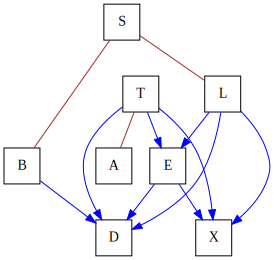

In [56]:
graph = pc.graph_

draw(graph, direction='TB')

Compare this against the ground truth CPDAG, which should match exactly.

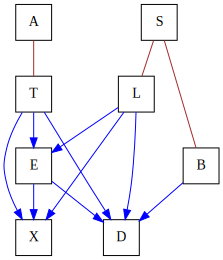

In [57]:
draw(ground_truth_cpdag, direction='TB')

In [58]:
match_directed = nx.is_isomorphic(ground_truth_cpdag.sub_directed_graph(), graph.sub_directed_graph())
match_undirected = nx.is_isomorphic(ground_truth_cpdag.sub_undirected_graph(), graph.sub_undirected_graph())

print(f'The oracle learned CPDAG via the PC algorithm matches the ground truth in directed edges: {match_directed} \n'
      f'and matches the undirected edges: {match_undirected}')

The oracle learned CPDAG via the PC algorithm matches the ground truth in directed edges: True 
and matches the undirected edges: True


Now, we will show the output given a real CI test, which performs CI hypothesis testing to determine CI in the data. Due to finite data and the presence of noise, there is always a possibility that the CI test makes a mistake. In order to maximize the chances that the graph is correct, you want to ensure that the CI test you are using matches the assumptions you have on your data. 

For example, the G^2 binary test is a well-suited test for binary data, which we validated is the type of data we have for the ASIA dataset.

In [9]:
ci_estimator = GSquareCITest(data_type="binary")
pc = PC(ci_estimator=ci_estimator, alpha=0.05)

In [10]:
pc.learn_graph(data, context)

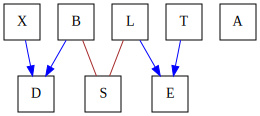

In [11]:
graph = pc.graph_
draw(graph, direction='TB')

The resulting graph captures some of the graph but not all of it.  The problem here is a violation of the [faithfulness assumption](https://plato.stanford.edu/entries/causal-models/#MiniFaitCond); e.g. in the Asia data, it is very hard to detect the edge between E and X. This highlights a common problem with causal discovery, where the inability to detect certain edges may lead to incorrect orientations.

Beyond faithfulness violations, in general causal discovery algorithms struggle when there is no user-provided causal knowledge to constrain the problem.  A core philosophy of dodiscovery is that causal domain knowledge should be provided to constrain the problem, and providing it should be easy.  For example, for this data, we know that smoking (S) causes both lung cancer (L) and bronchitis (B) and not the other way around.

## References

Lauritzen S, Spiegelhalter D (1988). "Local Computation with Probabilities on Graphical Structures and their Application to Expert Systems (with discussion)". Journal of the Royal Statistical Society: Series B, 50(2):157–224.
